In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf

plt.style.use('ggplot')

In [4]:
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(50000)
print(df.shape)

(568454, 10)
(50000, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


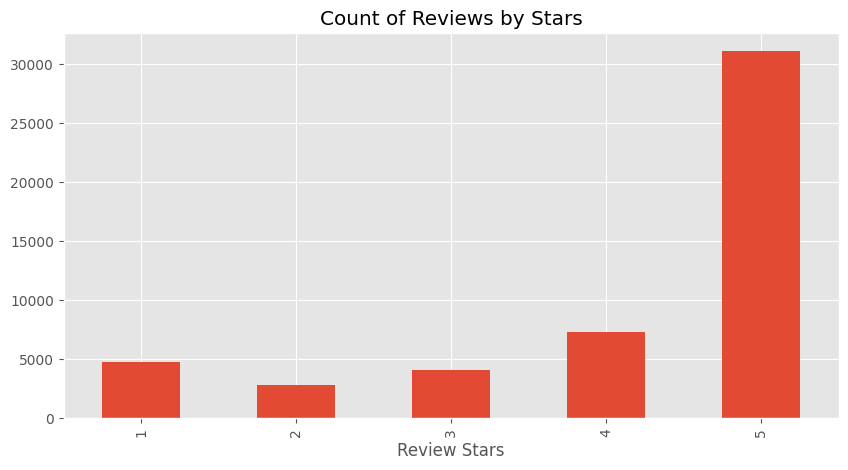

In [6]:
ax=df['Score'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
#NLTK

In [11]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [12]:
from nltk.tokenize import word_tokenize

In [13]:
#Dependency to install if using NLTK for the first time

# import nltk
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')

In [14]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [15]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [16]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [17]:
#VADER Sentiment Scoring
# nltk.download('vader_lexicon')

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [20]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [21]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [22]:
from tqdm.notebook import tqdm
from tqdm import tqdm


In [23]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:38<00:00, 1298.36it/s]


In [24]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [25]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


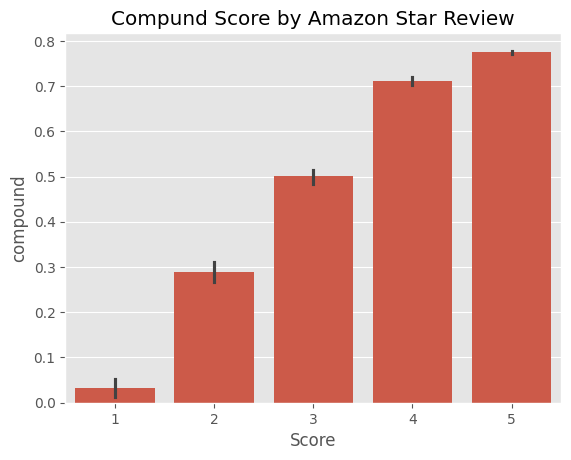

In [26]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

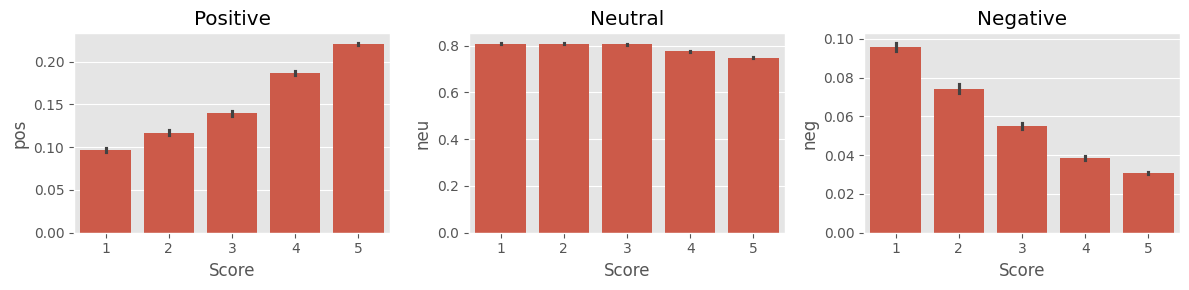

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [28]:
#Roberta Pretrained model 

In [29]:
# !pip install transformers scipy --upgrade

In [30]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [32]:
# VADER results on example
print(example)
sia.polarity_scores(example)


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [33]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573692}


In [34]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [35]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']

        # Skip empty or invalid text
        if not isinstance(text, str) or not text.strip():
            continue

        # VADER sentiment
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}

        # RoBERTa sentiment
        roberta_result = polarity_scores_roberta(text)

        # Combine results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both

    except Exception:
        print(f"Error processing ID {myid}")
        continue


  0%|▏                                                                            | 84/50000 [00:07<1:09:29, 11.97it/s]

Error processing ID 83


  0%|▎                                                                             | 188/50000 [00:16<55:04, 15.07it/s]

Error processing ID 187


  1%|▊                                                                           | 531/50000 [00:48<1:14:33, 11.06it/s]

Error processing ID 529


  1%|▊                                                                             | 542/50000 [00:49<59:14, 13.92it/s]

Error processing ID 540


  1%|█▏                                                                          | 747/50000 [01:09<1:32:12,  8.90it/s]

Error processing ID 746


  2%|█▎                                                                          | 862/50000 [01:19<1:15:21, 10.87it/s]

Error processing ID 863


  2%|█▌                                                                         | 1054/50000 [01:36<1:03:02, 12.94it/s]

Error processing ID 1053


  2%|█▋                                                                           | 1072/50000 [01:38<57:54, 14.08it/s]

Error processing ID 1070


  2%|█▊                                                                           | 1158/50000 [01:45<50:40, 16.06it/s]

Error processing ID 1156


  3%|█▉                                                                         | 1322/50000 [01:59<1:00:10, 13.48it/s]

Error processing ID 1321


  3%|██                                                                         | 1375/50000 [02:03<1:25:32,  9.47it/s]

Error processing ID 1375


  3%|██▏                                                                        | 1496/50000 [02:14<1:02:03, 13.03it/s]

Error processing ID 1498


  3%|██▎                                                                        | 1576/50000 [02:22<1:34:34,  8.53it/s]

Error processing ID 1575


  4%|██▊                                                                          | 1797/50000 [02:41<52:22, 15.34it/s]

Error processing ID 1796


  4%|██▋                                                                        | 1827/50000 [02:44<1:12:12, 11.12it/s]

Error processing ID 1826


  4%|███▎                                                                       | 2168/50000 [03:17<1:10:40, 11.28it/s]

Error processing ID 2169


  4%|███▎                                                                       | 2249/50000 [03:24<1:03:12, 12.59it/s]

Error processing ID 2248


  5%|███▋                                                                       | 2477/50000 [03:44<1:08:12, 11.61it/s]

Error processing ID 2476


  5%|███▋                                                                       | 2494/50000 [03:46<1:00:34, 13.07it/s]

Error processing ID 2492


  5%|███▉                                                                         | 2585/50000 [03:54<55:13, 14.31it/s]

Error processing ID 2584


  5%|███▉                                                                       | 2611/50000 [03:56<1:15:21, 10.48it/s]

Error processing ID 2610


  6%|████▍                                                                        | 2900/50000 [04:23<54:59, 14.27it/s]

Error processing ID 2897
Error processing ID 2898
Error processing ID 2902


  6%|████▍                                                                      | 2930/50000 [04:25<1:04:28, 12.17it/s]

Error processing ID 2928


  6%|████▍                                                                      | 2945/50000 [04:26<1:01:58, 12.65it/s]

Error processing ID 2942
Error processing ID 2944


  6%|████▌                                                                        | 2947/50000 [04:26<56:37, 13.85it/s]

Error processing ID 2947
Error processing ID 2948


  6%|████▋                                                                        | 3024/50000 [04:33<56:57, 13.75it/s]

Error processing ID 3022
Error processing ID 3023
Error processing ID 3025


  7%|████▉                                                                      | 3307/50000 [04:58<1:02:57, 12.36it/s]

Error processing ID 3306


  8%|█████▊                                                                       | 3790/50000 [05:38<56:32, 13.62it/s]

Error processing ID 3788


  8%|██████                                                                       | 3970/50000 [05:52<51:16, 14.96it/s]

Error processing ID 3969


  8%|██████▏                                                                    | 4109/50000 [06:06<1:01:32, 12.43it/s]

Error processing ID 4107
Error processing ID 4110


  9%|██████▍                                                                    | 4308/50000 [06:24<1:07:04, 11.35it/s]

Error processing ID 4307


  9%|██████▍                                                                    | 4317/50000 [06:25<1:23:39,  9.10it/s]

Error processing ID 4316


  9%|██████▊                                                                      | 4410/50000 [06:32<51:51, 14.65it/s]

Error processing ID 4408


  9%|██████▉                                                                      | 4484/50000 [06:38<44:22, 17.09it/s]

Error processing ID 4483


  9%|██████▊                                                                    | 4513/50000 [06:41<1:07:40, 11.20it/s]

Error processing ID 4512


  9%|██████▊                                                                    | 4553/50000 [06:46<1:02:59, 12.02it/s]

Error processing ID 4553


  9%|██████▉                                                                    | 4584/50000 [06:50<1:40:51,  7.51it/s]

Error processing ID 4583


 10%|███████▊                                                                     | 5041/50000 [07:50<59:50, 12.52it/s]

Error processing ID 5040


 10%|███████▉                                                                     | 5183/50000 [08:03<56:07, 13.31it/s]

Error processing ID 5182


 10%|███████▊                                                                   | 5191/50000 [08:04<2:06:38,  5.90it/s]

Error processing ID 5192


 11%|████████                                                                   | 5366/50000 [08:20<1:01:49, 12.03it/s]

Error processing ID 5365


 11%|████████▏                                                                  | 5443/50000 [08:28<1:10:35, 10.52it/s]

Error processing ID 5442


 11%|████████▊                                                                    | 5710/50000 [08:52<55:01, 13.41it/s]

Error processing ID 5709


 12%|█████████▏                                                                   | 5999/50000 [09:19<50:08, 14.63it/s]

Error processing ID 5998


 12%|█████████                                                                  | 6005/50000 [09:19<1:02:55, 11.65it/s]

Error processing ID 6003


 12%|█████████                                                                  | 6009/50000 [09:20<1:13:28,  9.98it/s]

Error processing ID 6007


 12%|█████████▍                                                                   | 6108/50000 [09:29<53:03, 13.79it/s]

Error processing ID 6106


 12%|█████████▎                                                                 | 6235/50000 [09:40<1:10:46, 10.31it/s]

Error processing ID 6234


 13%|█████████▊                                                                 | 6557/50000 [10:11<1:16:37,  9.45it/s]

Error processing ID 6558


 13%|█████████▉                                                                 | 6649/50000 [10:21<2:59:17,  4.03it/s]

Error processing ID 6651


 14%|██████████▏                                                                | 6800/50000 [10:43<1:13:17,  9.82it/s]

Error processing ID 6798


 14%|██████████▎                                                                | 6839/50000 [10:48<1:25:49,  8.38it/s]

Error processing ID 6838


 14%|██████████▎                                                                | 6851/50000 [10:50<1:33:37,  7.68it/s]

Error processing ID 6850


 14%|██████████▎                                                                | 6888/50000 [10:55<1:00:51, 11.81it/s]

Error processing ID 6886


 14%|██████████▎                                                                | 6904/50000 [10:57<2:07:28,  5.63it/s]

Error processing ID 6905


 14%|██████████▍                                                                | 6955/50000 [11:04<1:05:05, 11.02it/s]

Error processing ID 6955


 14%|██████████▌                                                                | 7078/50000 [11:17<1:23:39,  8.55it/s]

Error processing ID 7077


 14%|██████████▉                                                                  | 7088/50000 [11:18<57:52, 12.36it/s]

Error processing ID 7088


 14%|███████████                                                                  | 7202/50000 [11:30<58:36, 12.17it/s]

Error processing ID 7201


 15%|███████████▍                                                               | 7604/50000 [12:10<1:04:37, 10.93it/s]

Error processing ID 7604


 15%|███████████▍                                                               | 7608/50000 [12:10<1:02:40, 11.27it/s]

Error processing ID 7608


 15%|███████████▌                                                               | 7670/50000 [12:16<1:12:57,  9.67it/s]

Error processing ID 7671


 15%|███████████▌                                                               | 7702/50000 [12:21<1:10:48,  9.96it/s]

Error processing ID 7701


 16%|████████████                                                                 | 7812/50000 [12:32<58:05, 12.10it/s]

Error processing ID 7810


 16%|███████████▊                                                               | 7909/50000 [12:44<2:07:11,  5.52it/s]

Error processing ID 7907


 16%|████████████                                                               | 8076/50000 [13:18<1:54:28,  6.10it/s]

Error processing ID 8077


 16%|████████████▏                                                              | 8132/50000 [13:30<1:25:21,  8.17it/s]

Error processing ID 8131


 17%|████████████▍                                                              | 8265/50000 [13:54<1:55:35,  6.02it/s]

Error processing ID 8266


 17%|█████████████                                                              | 8739/50000 [15:04<1:39:35,  6.91it/s]

Error processing ID 8740


 18%|█████████████▏                                                             | 8758/50000 [15:07<1:15:29,  9.10it/s]

Error processing ID 8757


 18%|█████████████▊                                                               | 8937/50000 [15:35<50:54, 13.44it/s]

Error processing ID 8935


 19%|██████████████▍                                                            | 9591/50000 [16:45<1:24:46,  7.94it/s]

Error processing ID 9590


 20%|██████████████▊                                                            | 9851/50000 [17:15<1:29:30,  7.48it/s]

Error processing ID 9850


 20%|██████████████▊                                                            | 9880/50000 [17:19<1:40:44,  6.64it/s]

Error processing ID 9881


 20%|██████████████▊                                                            | 9912/50000 [17:23<1:23:36,  7.99it/s]

Error processing ID 9910


 20%|██████████████▉                                                            | 9924/50000 [17:25<1:48:10,  6.17it/s]

Error processing ID 9923


 20%|██████████████▊                                                           | 10003/50000 [17:35<1:16:54,  8.67it/s]

Error processing ID 10002


 20%|██████████████▊                                                           | 10006/50000 [17:35<1:23:24,  7.99it/s]

Error processing ID 10005


 20%|██████████████▊                                                           | 10031/50000 [17:38<1:03:06, 10.56it/s]

Error processing ID 10031


 21%|███████████████▌                                                          | 10551/50000 [18:30<1:03:32, 10.35it/s]

Error processing ID 10550


 22%|████████████████▍                                                           | 10838/50000 [18:56<51:42, 12.62it/s]

Error processing ID 10837


 22%|████████████████▌                                                           | 10866/50000 [18:58<39:09, 16.66it/s]

Error processing ID 10861
Error processing ID 10862
Error processing ID 10863
Error processing ID 10864


 22%|████████████████▌                                                           | 10887/50000 [19:00<42:48, 15.23it/s]

Error processing ID 10885


 22%|████████████████▌                                                           | 10925/50000 [19:04<50:53, 12.79it/s]

Error processing ID 10924


 22%|████████████████▋                                                           | 10947/50000 [19:05<45:54, 14.18it/s]

Error processing ID 10946


 22%|████████████████▏                                                         | 10970/50000 [19:08<1:14:17,  8.76it/s]

Error processing ID 10969


 22%|████████████████▉                                                           | 11115/50000 [19:21<48:54, 13.25it/s]

Error processing ID 11114


 22%|█████████████████                                                           | 11241/50000 [19:33<36:46, 17.57it/s]

Error processing ID 11238
Error processing ID 11239


 22%|█████████████████                                                           | 11247/50000 [19:34<44:09, 14.63it/s]

Error processing ID 11245


 23%|█████████████████▏                                                          | 11301/50000 [19:38<43:22, 14.87it/s]

Error processing ID 11302


 23%|████████████████▊                                                         | 11378/50000 [19:45<1:02:31, 10.30it/s]

Error processing ID 11376


 23%|█████████████████▍                                                          | 11473/50000 [19:53<41:56, 15.31it/s]

Error processing ID 11471


 23%|█████████████████▌                                                          | 11522/50000 [19:58<50:47, 12.63it/s]

Error processing ID 11520


 23%|█████████████████▌                                                          | 11583/50000 [20:03<43:07, 14.85it/s]

Error processing ID 11582


 23%|█████████████████▊                                                          | 11727/50000 [20:16<53:29, 11.93it/s]

Error processing ID 11726


 24%|█████████████████▍                                                        | 11804/50000 [20:23<1:06:17,  9.60it/s]

Error processing ID 11803


 24%|██████████████████                                                          | 11877/50000 [20:28<34:42, 18.30it/s]

Error processing ID 11876


 24%|██████████████████▏                                                         | 11940/50000 [20:35<47:02, 13.48it/s]

Error processing ID 11939


 24%|██████████████████▎                                                         | 12011/50000 [20:40<48:00, 13.19it/s]

Error processing ID 12009


 24%|█████████████████▊                                                        | 12043/50000 [20:43<1:13:42,  8.58it/s]

Error processing ID 12044


 24%|█████████████████▊                                                        | 12048/50000 [20:44<1:02:10, 10.17it/s]

Error processing ID 12050


 24%|██████████████████▌                                                         | 12230/50000 [21:00<51:52, 12.14it/s]

Error processing ID 12228


 24%|██████████████████                                                        | 12240/50000 [21:01<1:02:59,  9.99it/s]

Error processing ID 12241


 25%|██████████████████▋                                                         | 12265/50000 [21:03<47:00, 13.38it/s]

Error processing ID 12264


 25%|██████████████████▏                                                       | 12305/50000 [21:07<1:00:23, 10.40it/s]

Error processing ID 12304


 25%|███████████████████▎                                                        | 12736/50000 [21:51<57:50, 10.74it/s]

Error processing ID 12736


 26%|███████████████████▍                                                        | 12827/50000 [21:59<44:11, 14.02it/s]

Error processing ID 12824


 26%|███████████████████▊                                                        | 13068/50000 [22:21<55:40, 11.06it/s]

Error processing ID 13065


 26%|███████████████████▍                                                      | 13097/50000 [22:25<1:13:04,  8.42it/s]

Error processing ID 13095


 26%|███████████████████▍                                                      | 13167/50000 [22:34<1:14:30,  8.24it/s]

Error processing ID 13166


 26%|███████████████████▌                                                      | 13185/50000 [22:36<1:03:25,  9.68it/s]

Error processing ID 13184


 26%|███████████████████▌                                                      | 13200/50000 [22:38<1:10:30,  8.70it/s]

Error processing ID 13200


 27%|████████████████████▏                                                       | 13281/50000 [22:45<46:20, 13.21it/s]

Error processing ID 13280


 27%|████████████████████▏                                                       | 13283/50000 [22:45<47:30, 12.88it/s]

Error processing ID 13282


 27%|████████████████████▏                                                       | 13296/50000 [22:47<54:47, 11.16it/s]

Error processing ID 13294


 27%|████████████████████▌                                                       | 13519/50000 [23:09<41:29, 14.65it/s]

Error processing ID 13518


 27%|████████████████████▎                                                     | 13716/50000 [23:26<1:01:06,  9.90it/s]

Error processing ID 13715


 28%|█████████████████████▏                                                      | 13900/50000 [23:43<58:22, 10.31it/s]

Error processing ID 13898


 28%|████████████████████▋                                                     | 14013/50000 [23:54<1:00:41,  9.88it/s]

Error processing ID 14012


 28%|████████████████████▊                                                     | 14041/50000 [23:58<1:45:55,  5.66it/s]

Error processing ID 14042


 28%|████████████████████▊                                                     | 14047/50000 [23:59<1:09:23,  8.64it/s]

Error processing ID 14046


 28%|████████████████████▊                                                     | 14063/50000 [24:01<1:20:32,  7.44it/s]

Error processing ID 14062


 28%|████████████████████▊                                                     | 14076/50000 [24:03<1:26:55,  6.89it/s]

Error processing ID 14077


 28%|████████████████████▊                                                     | 14091/50000 [24:06<1:57:27,  5.10it/s]

Error processing ID 14092


 28%|████████████████████▊                                                     | 14096/50000 [24:07<1:44:14,  5.74it/s]

Error processing ID 14098
Error processing ID 14099


 28%|████████████████████▉                                                     | 14109/50000 [24:09<1:49:58,  5.44it/s]

Error processing ID 14111


 28%|████████████████████▉                                                     | 14129/50000 [24:11<1:05:21,  9.15it/s]

Error processing ID 14128


 28%|████████████████████▉                                                     | 14156/50000 [24:16<1:18:17,  7.63it/s]

Error processing ID 14157


 28%|█████████████████████                                                     | 14206/50000 [24:23<1:41:40,  5.87it/s]

Error processing ID 14207


 29%|█████████████████████                                                     | 14254/50000 [24:29<1:07:40,  8.80it/s]

Error processing ID 14254


 29%|█████████████████████▋                                                      | 14273/50000 [24:31<59:50,  9.95it/s]

Error processing ID 14273


 30%|██████████████████████▍                                                     | 14765/50000 [25:16<41:05, 14.29it/s]

Error processing ID 14764


 30%|██████████████████████▍                                                     | 14787/50000 [25:19<45:43, 12.83it/s]

Error processing ID 14785


 30%|██████████████████████▋                                                     | 14898/50000 [25:29<47:16, 12.37it/s]

Error processing ID 14896


 30%|██████████████████████▋                                                     | 14916/50000 [25:31<45:28, 12.86it/s]

Error processing ID 14914


 30%|██████████████████████▌                                                   | 15217/50000 [25:59<1:11:32,  8.10it/s]

Error processing ID 15217


 30%|██████████████████████▌                                                   | 15221/50000 [26:00<2:08:06,  4.52it/s]

Error processing ID 15222


 31%|███████████████████████▍                                                    | 15403/50000 [26:23<54:51, 10.51it/s]

Error processing ID 15401


 31%|███████████████████████▊                                                    | 15706/50000 [26:52<41:07, 13.90it/s]

Error processing ID 15704


 32%|███████████████████████▉                                                    | 15768/50000 [26:56<37:11, 15.34it/s]

Error processing ID 15765


 32%|████████████████████████                                                    | 15830/50000 [27:02<52:46, 10.79it/s]

Error processing ID 15829


 32%|████████████████████████▍                                                   | 16054/50000 [27:22<54:39, 10.35it/s]

Error processing ID 16054


 32%|███████████████████████▊                                                  | 16056/50000 [27:23<1:08:26,  8.27it/s]

Error processing ID 16056


 32%|████████████████████████▋                                                   | 16216/50000 [27:40<39:34, 14.23it/s]

Error processing ID 16215


 33%|████████████████████████▍                                                 | 16545/50000 [28:05<1:04:21,  8.66it/s]

Error processing ID 16544


 33%|█████████████████████████▍                                                  | 16749/50000 [28:33<59:29,  9.31it/s]

Error processing ID 16748


 34%|█████████████████████████▍                                                  | 16755/50000 [28:33<56:36,  9.79it/s]

Error processing ID 16754


 34%|████████████████████████▉                                                 | 16834/50000 [28:43<1:05:00,  8.50it/s]

Error processing ID 16835


 34%|█████████████████████████▋                                                  | 16861/50000 [28:46<48:06, 11.48it/s]

Error processing ID 16860


 34%|█████████████████████████▏                                                | 17016/50000 [29:05<1:02:29,  8.80it/s]

Error processing ID 17014


 34%|█████████████████████████▉                                                  | 17084/50000 [29:11<47:49, 11.47it/s]

Error processing ID 17083


 34%|██████████████████████████                                                  | 17150/50000 [29:17<36:17, 15.08it/s]

Error processing ID 17148
Error processing ID 17149


 35%|█████████████████████████▌                                                | 17261/50000 [29:28<1:02:03,  8.79it/s]

Error processing ID 17260


 35%|██████████████████████████▏                                               | 17731/50000 [30:09<1:10:35,  7.62it/s]

Error processing ID 17731


 36%|███████████████████████████▎                                                | 17941/50000 [30:28<44:46, 11.93it/s]

Error processing ID 17939


 36%|███████████████████████████▍                                                | 18030/50000 [30:36<52:26, 10.16it/s]

Error processing ID 18028


 36%|███████████████████████████▋                                                | 18193/50000 [30:52<49:02, 10.81it/s]

Error processing ID 18192


 36%|███████████████████████████▋                                                | 18247/50000 [30:56<34:30, 15.33it/s]

Error processing ID 18245


 37%|███████████████████████████▊                                                | 18323/50000 [31:04<40:11, 13.13it/s]

Error processing ID 18321


 37%|███████████████████████████▉                                                | 18343/50000 [31:06<52:44, 10.00it/s]

Error processing ID 18343


 37%|████████████████████████████                                                | 18492/50000 [31:20<41:44, 12.58it/s]

Error processing ID 18491


 37%|████████████████████████████▏                                               | 18522/50000 [31:23<42:47, 12.26it/s]

Error processing ID 18523


 37%|████████████████████████████▏                                               | 18559/50000 [31:26<41:48, 12.53it/s]

Error processing ID 18559


 37%|███████████████████████████▌                                              | 18637/50000 [31:34<1:22:08,  6.36it/s]

Error processing ID 18638


 38%|████████████████████████████▌                                               | 18759/50000 [31:46<40:35, 12.83it/s]

Error processing ID 18760


 38%|████████████████████████████▋                                               | 18865/50000 [31:58<50:07, 10.35it/s]

Error processing ID 18865


 38%|███████████████████████████▉                                              | 18871/50000 [31:59<1:11:45,  7.23it/s]

Error processing ID 18870


 38%|████████████████████████████▋                                               | 18878/50000 [31:59<44:10, 11.74it/s]

Error processing ID 18877


 38%|████████████████████████████▊                                               | 18952/50000 [32:07<50:31, 10.24it/s]

Error processing ID 18950


 38%|█████████████████████████████                                               | 19091/50000 [32:19<47:08, 10.93it/s]

Error processing ID 19090


 38%|█████████████████████████████                                               | 19137/50000 [32:24<35:53, 14.33it/s]

Error processing ID 19134


 39%|█████████████████████████████▌                                              | 19410/50000 [32:51<31:45, 16.05it/s]

Error processing ID 19408


 39%|█████████████████████████████▋                                              | 19525/50000 [33:02<47:28, 10.70it/s]

Error processing ID 19523


 39%|████████████████████████████▉                                             | 19545/50000 [33:04<1:01:15,  8.29it/s]

Error processing ID 19544


 39%|████████████████████████████▉                                             | 19559/50000 [33:06<1:08:52,  7.37it/s]

Error processing ID 19560


 39%|████████████████████████████▉                                             | 19567/50000 [33:07<1:03:45,  7.96it/s]

Error processing ID 19568


 39%|████████████████████████████▉                                             | 19570/50000 [33:07<1:04:00,  7.92it/s]

Error processing ID 19571


 39%|████████████████████████████▉                                             | 19572/50000 [33:07<1:01:31,  8.24it/s]

Error processing ID 19574


 39%|████████████████████████████▉                                             | 19587/50000 [33:10<1:36:07,  5.27it/s]

Error processing ID 19588


 39%|█████████████████████████████▊                                              | 19611/50000 [33:13<54:27,  9.30it/s]

Error processing ID 19610


 39%|█████████████████████████████▊                                              | 19647/50000 [33:18<47:39, 10.61it/s]

Error processing ID 19646


 40%|██████████████████████████████▏                                             | 19827/50000 [33:34<56:25,  8.91it/s]

Error processing ID 19828


 40%|██████████████████████████████▏                                             | 19848/50000 [33:36<52:49,  9.51it/s]

Error processing ID 19849


 40%|██████████████████████████████▏                                             | 19855/50000 [33:37<55:20,  9.08it/s]

Error processing ID 19854


 40%|██████████████████████████████▊                                             | 20233/50000 [34:12<35:35, 13.94it/s]

Error processing ID 20230


 41%|██████████████████████████████▉                                             | 20344/50000 [34:29<49:39,  9.95it/s]

Error processing ID 20344
Error processing ID 20345


 41%|██████████████████████████████▉                                             | 20360/50000 [34:31<59:21,  8.32it/s]

Error processing ID 20358


 41%|██████████████████████████████▏                                           | 20397/50000 [34:37<1:41:23,  4.87it/s]

Error processing ID 20398


 41%|███████████████████████████████                                             | 20414/50000 [34:39<59:47,  8.25it/s]

Error processing ID 20414


 41%|██████████████████████████████▏                                           | 20419/50000 [34:40<1:08:16,  7.22it/s]

Error processing ID 20418
Error processing ID 20420


 41%|███████████████████████████████                                             | 20430/50000 [34:41<50:02,  9.85it/s]

Error processing ID 20428


 41%|██████████████████████████████▏                                           | 20433/50000 [34:42<1:17:16,  6.38it/s]

Error processing ID 20434
Error processing ID 20435


 41%|███████████████████████████████                                             | 20439/50000 [34:43<57:20,  8.59it/s]

Error processing ID 20437
Error processing ID 20438


 41%|██████████████████████████████▎                                           | 20461/50000 [34:45<1:02:47,  7.84it/s]

Error processing ID 20461


 41%|██████████████████████████████▎                                           | 20485/50000 [34:49<1:06:27,  7.40it/s]

Error processing ID 20484


 41%|███████████████████████████████▏                                            | 20496/50000 [34:51<49:56,  9.85it/s]

Error processing ID 20497


 41%|███████████████████████████████▏                                            | 20504/50000 [34:52<49:12,  9.99it/s]

Error processing ID 20502
Error processing ID 20503


 41%|███████████████████████████████▏                                            | 20512/50000 [34:52<44:41, 11.00it/s]

Error processing ID 20511


 41%|███████████████████████████████▏                                            | 20533/50000 [34:54<34:41, 14.16it/s]

Error processing ID 20531


 41%|███████████████████████████████▏                                            | 20538/50000 [34:54<33:45, 14.55it/s]

Error processing ID 20536


 41%|██████████████████████████████▋                                           | 20740/50000 [35:14<1:02:29,  7.80it/s]

Error processing ID 20741
Error processing ID 20742


 42%|███████████████████████████████▊                                            | 20920/50000 [35:31<42:50, 11.31it/s]

Error processing ID 20918


 42%|███████████████████████████████▊                                            | 20933/50000 [35:32<34:18, 14.12it/s]

Error processing ID 20931


 42%|████████████████████████████████                                            | 21118/50000 [35:47<34:38, 13.90it/s]

Error processing ID 21117


 43%|████████████████████████████████▊                                           | 21627/50000 [36:31<37:20, 12.66it/s]

Error processing ID 21626


 43%|█████████████████████████████████                                           | 21716/50000 [36:39<44:41, 10.55it/s]

Error processing ID 21714


 44%|█████████████████████████████████▏                                          | 21821/50000 [36:51<42:22, 11.08it/s]

Error processing ID 21820


 44%|████████████████████████████████▍                                         | 21941/50000 [37:06<1:01:34,  7.59it/s]

Error processing ID 21940


 44%|█████████████████████████████████▍                                          | 22006/50000 [37:14<56:02,  8.33it/s]

Error processing ID 22005


 45%|█████████████████████████████████▊                                          | 22257/50000 [37:43<42:57, 10.76it/s]

Error processing ID 22256


 45%|█████████████████████████████████▉                                          | 22301/50000 [37:49<34:19, 13.45it/s]

Error processing ID 22299


 45%|██████████████████████████████████▏                                         | 22482/50000 [38:05<29:44, 15.42it/s]

Error processing ID 22479


 45%|██████████████████████████████████▏                                         | 22485/50000 [38:06<28:23, 16.15it/s]

Error processing ID 22484


 45%|██████████████████████████████████▏                                         | 22487/50000 [38:06<40:58, 11.19it/s]

Error processing ID 22487


 46%|██████████████████████████████████▉                                         | 22953/50000 [38:53<45:02, 10.01it/s]

Error processing ID 22952


 46%|██████████████████████████████████▉                                         | 22972/50000 [38:56<43:03, 10.46it/s]

Error processing ID 22971


 46%|██████████████████████████████████▉                                         | 23018/50000 [39:02<48:41,  9.24it/s]

Error processing ID 23017


 46%|███████████████████████████████████                                         | 23038/50000 [39:05<35:28, 12.66it/s]

Error processing ID 23036


 46%|███████████████████████████████████                                         | 23089/50000 [39:12<49:30,  9.06it/s]

Error processing ID 23088


 46%|███████████████████████████████████▏                                        | 23111/50000 [39:15<50:09,  8.93it/s]

Error processing ID 23110


 46%|███████████████████████████████████▏                                        | 23141/50000 [39:19<56:50,  7.88it/s]

Error processing ID 23140
Error processing ID 23143


 46%|███████████████████████████████████▎                                        | 23202/50000 [39:29<58:28,  7.64it/s]

Error processing ID 23201


 47%|███████████████████████████████████▌                                        | 23418/50000 [39:50<40:08, 11.04it/s]

Error processing ID 23417


 47%|███████████████████████████████████▌                                        | 23426/50000 [39:51<47:15,  9.37it/s]

Error processing ID 23425


 47%|██████████████████████████████████▋                                       | 23428/50000 [39:52<1:01:39,  7.18it/s]

Error processing ID 23429


 47%|███████████████████████████████████▉                                        | 23665/50000 [40:16<36:27, 12.04it/s]

Error processing ID 23663


 47%|████████████████████████████████████                                        | 23702/50000 [40:20<33:57, 12.91it/s]

Error processing ID 23700


 48%|████████████████████████████████████▎                                       | 23862/50000 [40:36<32:48, 13.28it/s]

Error processing ID 23860


 49%|████████████████████████████████████▊                                       | 24256/50000 [41:14<40:33, 10.58it/s]

Error processing ID 24254


 49%|█████████████████████████████████████▎                                      | 24524/50000 [41:41<33:15, 12.77it/s]

Error processing ID 24523


 49%|█████████████████████████████████████▎                                      | 24585/50000 [41:46<32:19, 13.11it/s]

Error processing ID 24586


 49%|█████████████████████████████████████▍                                      | 24592/50000 [41:47<59:20,  7.14it/s]

Error processing ID 24591


 49%|█████████████████████████████████████▍                                      | 24602/50000 [41:49<51:34,  8.21it/s]

Error processing ID 24601


 49%|█████████████████████████████████████▌                                      | 24709/50000 [41:59<27:28, 15.34it/s]

Error processing ID 24707


 50%|█████████████████████████████████████▊                                      | 24836/50000 [42:12<56:16,  7.45it/s]

Error processing ID 24837


 50%|██████████████████████████████████████▏                                     | 25118/50000 [42:38<48:27,  8.56it/s]

Error processing ID 25117


 51%|██████████████████████████████████████▍                                     | 25258/50000 [42:52<34:37, 11.91it/s]

Error processing ID 25258


 51%|██████████████████████████████████████▌                                     | 25365/50000 [43:03<30:19, 13.54it/s]

Error processing ID 25363


 51%|██████████████████████████████████████▋                                     | 25449/50000 [43:11<35:19, 11.58it/s]

Error processing ID 25448


 51%|██████████████████████████████████████▋                                     | 25477/50000 [43:14<25:33, 15.99it/s]

Error processing ID 25472
Error processing ID 25473
Error processing ID 25474
Error processing ID 25475


 51%|██████████████████████████████████████▊                                     | 25498/50000 [43:15<27:19, 14.95it/s]

Error processing ID 25496


 51%|██████████████████████████████████████▊                                     | 25544/50000 [43:19<30:14, 13.47it/s]

Error processing ID 25543


 51%|██████████████████████████████████████▉                                     | 25580/50000 [43:22<38:11, 10.66it/s]

Error processing ID 25578


 51%|██████████████████████████████████████▉                                     | 25585/50000 [43:23<29:04, 14.00it/s]

Error processing ID 25582
Error processing ID 25584


 52%|███████████████████████████████████████▋                                    | 26106/50000 [44:12<38:44, 10.28it/s]

Error processing ID 26104


 52%|███████████████████████████████████████▋                                    | 26117/50000 [44:12<28:27, 13.99it/s]

Error processing ID 26115


 52%|███████████████████████████████████████▊                                    | 26216/50000 [44:23<33:40, 11.77it/s]

Error processing ID 26215


 53%|████████████████████████████████████████▏                                   | 26401/50000 [44:42<36:50, 10.67it/s]

Error processing ID 26399


 54%|████████████████████████████████████████▉                                   | 26905/50000 [45:30<35:59, 10.70it/s]

Error processing ID 26906


 55%|█████████████████████████████████████████▊                                  | 27543/50000 [46:29<34:18, 10.91it/s]

Error processing ID 27541


 55%|█████████████████████████████████████████▉                                  | 27585/50000 [46:33<31:27, 11.87it/s]

Error processing ID 27585


 56%|██████████████████████████████████████████▏                                 | 27760/50000 [46:50<24:24, 15.19it/s]

Error processing ID 27758


 56%|██████████████████████████████████████████▍                                 | 27881/50000 [47:00<28:36, 12.89it/s]

Error processing ID 27880


 56%|██████████████████████████████████████████▍                                 | 27886/50000 [47:01<25:16, 14.58it/s]

Error processing ID 27884


 56%|██████████████████████████████████████████▉                                 | 28245/50000 [47:38<32:41, 11.09it/s]

Error processing ID 28247


 57%|██████████████████████████████████████████▉                                 | 28284/50000 [47:42<27:44, 13.05it/s]

Error processing ID 28283


 57%|███████████████████████████████████████████▏                                | 28426/50000 [47:54<33:34, 10.71it/s]

Error processing ID 28426


 58%|████████████████████████████████████████████                                | 28959/50000 [48:40<32:34, 10.76it/s]

Error processing ID 28958


 58%|████████████████████████████████████████████▏                               | 29107/50000 [48:54<27:55, 12.47it/s]

Error processing ID 29108


 58%|████████████████████████████████████████████▏                               | 29111/50000 [48:54<28:00, 12.43it/s]

Error processing ID 29110


 58%|████████████████████████████████████████████▎                               | 29121/50000 [48:55<26:18, 13.23it/s]

Error processing ID 29120


 59%|████████████████████████████████████████████▋                               | 29394/50000 [49:22<26:22, 13.02it/s]

Error processing ID 29392


 59%|████████████████████████████████████████████▉                               | 29553/50000 [49:36<31:37, 10.77it/s]

Error processing ID 29552


 59%|█████████████████████████████████████████████▏                              | 29749/50000 [49:54<23:51, 14.15it/s]

Error processing ID 29748


 60%|█████████████████████████████████████████████▋                              | 30019/50000 [50:19<30:32, 10.90it/s]

Error processing ID 30020


 60%|█████████████████████████████████████████████▋                              | 30096/50000 [50:26<43:17,  7.66it/s]

Error processing ID 30095


 61%|██████████████████████████████████████████████▋                             | 30716/50000 [51:23<24:20, 13.20it/s]

Error processing ID 30713


 62%|██████████████████████████████████████████████▉                             | 30874/50000 [51:40<28:45, 11.08it/s]

Error processing ID 30873


 63%|███████████████████████████████████████████████▊                            | 31418/50000 [52:32<22:17, 13.89it/s]

Error processing ID 31416


 63%|████████████████████████████████████████████████▏                           | 31695/50000 [52:57<29:17, 10.42it/s]

Error processing ID 31694


 64%|████████████████████████████████████████████████▎                           | 31784/50000 [53:05<21:09, 14.34it/s]

Error processing ID 31783


 64%|████████████████████████████████████████████████▌                           | 31986/50000 [53:24<34:15,  8.76it/s]

Error processing ID 31985


 64%|████████████████████████████████████████████████▋                           | 31996/50000 [53:25<25:00, 12.00it/s]

Error processing ID 31994


 64%|████████████████████████████████████████████████▋                           | 32056/50000 [53:31<27:25, 10.91it/s]

Error processing ID 32054


 64%|█████████████████████████████████████████████████                           | 32243/50000 [53:47<23:23, 12.65it/s]

Error processing ID 32242


 65%|█████████████████████████████████████████████████                           | 32266/50000 [53:49<25:05, 11.78it/s]

Error processing ID 32265
Error processing ID 32267


 65%|█████████████████████████████████████████████████▎                          | 32416/50000 [54:02<27:33, 10.63it/s]

Error processing ID 32415


 65%|█████████████████████████████████████████████████▎                          | 32429/50000 [54:04<28:29, 10.28it/s]

Error processing ID 32428


 65%|█████████████████████████████████████████████████▎                          | 32452/50000 [54:06<22:11, 13.18it/s]

Error processing ID 32451


 65%|█████████████████████████████████████████████████▌                          | 32645/50000 [54:23<25:46, 11.22it/s]

Error processing ID 32643


 65%|█████████████████████████████████████████████████▋                          | 32653/50000 [54:24<21:31, 13.43it/s]

Error processing ID 32653


 65%|█████████████████████████████████████████████████▊                          | 32734/50000 [54:30<25:10, 11.43it/s]

Error processing ID 32732


 66%|██████████████████████████████████████████████████▏                         | 32987/50000 [54:54<21:42, 13.06it/s]

Error processing ID 32986


 66%|██████████████████████████████████████████████████▏                         | 33050/50000 [54:59<19:31, 14.47it/s]

Error processing ID 33048


 66%|██████████████████████████████████████████████████▍                         | 33167/50000 [55:10<33:40,  8.33it/s]

Error processing ID 33166


 67%|██████████████████████████████████████████████████▋                         | 33344/50000 [55:28<28:19,  9.80it/s]

Error processing ID 33342


 67%|██████████████████████████████████████████████████▊                         | 33402/50000 [55:36<32:20,  8.55it/s]

Error processing ID 33401


 68%|███████████████████████████████████████████████████▍                        | 33854/50000 [56:18<15:34, 17.27it/s]

Error processing ID 33852
Error processing ID 33853


 68%|███████████████████████████████████████████████████▊                        | 34093/50000 [56:39<27:10,  9.76it/s]

Error processing ID 34092


 69%|████████████████████████████████████████████████████▏                       | 34300/50000 [56:57<25:45, 10.16it/s]

Error processing ID 34301


 69%|████████████████████████████████████████████████████▏                       | 34342/50000 [57:02<26:18,  9.92it/s]

Error processing ID 34340


 69%|████████████████████████████████████████████████████▏                       | 34353/50000 [57:03<19:29, 13.38it/s]

Error processing ID 34352


 69%|████████████████████████████████████████████████████▎                       | 34393/50000 [57:07<19:05, 13.63it/s]

Error processing ID 34392


 69%|████████████████████████████████████████████████████▌                       | 34570/50000 [57:24<20:21, 12.63it/s]

Error processing ID 34568


 69%|████████████████████████████████████████████████████▌                       | 34579/50000 [57:25<18:27, 13.92it/s]

Error processing ID 34578


 69%|████████████████████████████████████████████████████▊                       | 34705/50000 [57:36<15:31, 16.43it/s]

Error processing ID 34704


 69%|████████████████████████████████████████████████████▊                       | 34746/50000 [57:39<16:23, 15.52it/s]

Error processing ID 34744


 70%|████████████████████████████████████████████████████▉                       | 34792/50000 [57:44<22:42, 11.16it/s]

Error processing ID 34791


 70%|████████████████████████████████████████████████████▉                       | 34823/50000 [57:47<22:11, 11.39it/s]

Error processing ID 34822


 70%|█████████████████████████████████████████████████████▏                      | 34979/50000 [58:02<25:32,  9.80it/s]

Error processing ID 34980


 70%|█████████████████████████████████████████████████████▎                      | 35066/50000 [58:09<19:57, 12.47it/s]

Error processing ID 35066


 70%|█████████████████████████████████████████████████████▎                      | 35105/50000 [58:13<22:32, 11.02it/s]

Error processing ID 35105


 71%|█████████████████████████████████████████████████████▉                      | 35520/50000 [58:50<16:38, 14.50it/s]

Error processing ID 35519


 71%|██████████████████████████████████████████████████████                      | 35579/50000 [58:56<18:43, 12.83it/s]

Error processing ID 35578


 71%|██████████████████████████████████████████████████████▏                     | 35642/50000 [59:02<19:55, 12.01it/s]

Error processing ID 35639


 71%|██████████████████████████████████████████████████████▎                     | 35707/50000 [59:08<24:09,  9.86it/s]

Error processing ID 35706


 72%|██████████████████████████████████████████████████████▊                     | 36035/50000 [59:39<17:09, 13.57it/s]

Error processing ID 36033


 72%|██████████████████████████████████████████████████████▊                     | 36084/50000 [59:43<22:07, 10.48it/s]

Error processing ID 36082


 72%|██████████████████████████████████████████████████████▉                     | 36117/50000 [59:47<25:30,  9.07it/s]

Error processing ID 36116


 73%|█████████████████████████████████████████████████████▋                    | 36292/50000 [1:00:03<15:54, 14.36it/s]

Error processing ID 36289


 73%|█████████████████████████████████████████████████████▊                    | 36335/50000 [1:00:07<26:59,  8.44it/s]

Error processing ID 36336


 73%|█████████████████████████████████████████████████████▊                    | 36361/50000 [1:00:09<14:32, 15.63it/s]

Error processing ID 36358


 73%|█████████████████████████████████████████████████████▊                    | 36388/50000 [1:00:11<21:04, 10.76it/s]

Error processing ID 36386


 73%|█████████████████████████████████████████████████████▉                    | 36430/50000 [1:00:16<23:30,  9.62it/s]

Error processing ID 36429


 73%|█████████████████████████████████████████████████████▉                    | 36478/50000 [1:00:22<20:05, 11.21it/s]

Error processing ID 36479


 73%|██████████████████████████████████████████████████████▏                   | 36600/50000 [1:00:35<22:58,  9.72it/s]

Error processing ID 36598


 73%|██████████████████████████████████████████████████████▏                   | 36632/50000 [1:00:39<21:03, 10.58it/s]

Error processing ID 36631


 73%|██████████████████████████████████████████████████████▏                   | 36650/50000 [1:00:42<26:47,  8.30it/s]

Error processing ID 36649


 73%|██████████████████████████████████████████████████████▎                   | 36693/50000 [1:00:48<32:59,  6.72it/s]

Error processing ID 36694


 73%|██████████████████████████████████████████████████████▍                   | 36744/50000 [1:00:54<23:59,  9.21it/s]

Error processing ID 36746


 74%|██████████████████████████████████████████████████████▋                   | 36928/50000 [1:01:12<15:12, 14.32it/s]

Error processing ID 36928


 74%|██████████████████████████████████████████████████████▋                   | 36933/50000 [1:01:12<16:26, 13.24it/s]

Error processing ID 36931


 74%|██████████████████████████████████████████████████████▊                   | 37009/50000 [1:01:20<22:27,  9.64it/s]

Error processing ID 37008


 74%|██████████████████████████████████████████████████████▊                   | 37021/50000 [1:01:21<22:22,  9.67it/s]

Error processing ID 37021


 74%|██████████████████████████████████████████████████████▉                   | 37092/50000 [1:01:29<18:10, 11.84it/s]

Error processing ID 37092


 74%|██████████████████████████████████████████████████████▉                   | 37103/50000 [1:01:30<19:23, 11.08it/s]

Error processing ID 37102


 74%|██████████████████████████████████████████████████████▉                   | 37130/50000 [1:01:32<16:15, 13.19it/s]

Error processing ID 37129


 75%|███████████████████████████████████████████████████████▌                  | 37507/50000 [1:02:05<15:26, 13.49it/s]

Error processing ID 37506


 75%|███████████████████████████████████████████████████████▋                  | 37634/50000 [1:02:18<15:38, 13.18it/s]

Error processing ID 37633


 75%|███████████████████████████████████████████████████████▊                  | 37710/50000 [1:02:25<18:34, 11.02it/s]

Error processing ID 37709


 75%|███████████████████████████████████████████████████████▊                  | 37733/50000 [1:02:27<16:00, 12.77it/s]

Error processing ID 37731


 76%|████████████████████████████████████████████████████████▏                 | 37963/50000 [1:02:50<20:37,  9.73it/s]

Error processing ID 37962


 76%|████████████████████████████████████████████████████████▎                 | 38068/50000 [1:03:00<19:18, 10.30it/s]

Error processing ID 38066


 76%|████████████████████████████████████████████████████████▍                 | 38135/50000 [1:03:06<14:40, 13.47it/s]

Error processing ID 38134


 77%|████████████████████████████████████████████████████████▋                 | 38282/50000 [1:03:22<19:23, 10.07it/s]

Error processing ID 38281
Error processing ID 38283


 77%|████████████████████████████████████████████████████████▋                 | 38301/50000 [1:03:25<20:43,  9.41it/s]

Error processing ID 38300


 77%|████████████████████████████████████████████████████████▊                 | 38349/50000 [1:03:29<17:38, 11.01it/s]

Error processing ID 38347


 77%|████████████████████████████████████████████████████████▉                 | 38508/50000 [1:03:43<16:51, 11.37it/s]

Error processing ID 38507


 78%|█████████████████████████████████████████████████████████▍                | 38768/50000 [1:04:08<15:27, 12.11it/s]

Error processing ID 38767


 78%|█████████████████████████████████████████████████████████▍                | 38777/50000 [1:04:08<15:46, 11.86it/s]

Error processing ID 38776


 78%|█████████████████████████████████████████████████████████▌                | 38891/50000 [1:04:20<13:15, 13.97it/s]

Error processing ID 38890


 78%|█████████████████████████████████████████████████████████▊                | 39098/50000 [1:04:40<14:09, 12.83it/s]

Error processing ID 39098


 78%|█████████████████████████████████████████████████████████▉                | 39147/50000 [1:04:45<13:34, 13.32it/s]

Error processing ID 39145


 78%|██████████████████████████████████████████████████████████                | 39200/50000 [1:04:50<13:57, 12.90it/s]

Error processing ID 39198


 78%|██████████████████████████████████████████████████████████                | 39219/50000 [1:04:51<12:01, 14.94it/s]

Error processing ID 39217


 79%|██████████████████████████████████████████████████████████▎               | 39386/50000 [1:05:06<17:12, 10.28it/s]

Error processing ID 39384


 79%|██████████████████████████████████████████████████████████▍               | 39508/50000 [1:05:17<16:24, 10.65it/s]

Error processing ID 39507


 80%|██████████████████████████████████████████████████████████▉               | 39808/50000 [1:05:44<14:05, 12.06it/s]

Error processing ID 39806


 80%|███████████████████████████████████████████████████████████               | 39875/50000 [1:05:49<13:18, 12.68it/s]

Error processing ID 39874


 80%|███████████████████████████████████████████████████████████▎              | 40056/50000 [1:06:06<14:57, 11.07it/s]

Error processing ID 40058


 80%|███████████████████████████████████████████████████████████▎              | 40062/50000 [1:06:06<18:15,  9.07it/s]

Error processing ID 40061


 80%|███████████████████████████████████████████████████████████▎              | 40067/50000 [1:06:07<17:51,  9.27it/s]

Error processing ID 40065


 80%|███████████████████████████████████████████████████████████▍              | 40124/50000 [1:06:12<11:51, 13.87it/s]

Error processing ID 40122


 80%|███████████████████████████████████████████████████████████▌              | 40208/50000 [1:06:20<11:52, 13.75it/s]

Error processing ID 40207


 81%|███████████████████████████████████████████████████████████▌              | 40252/50000 [1:06:24<14:37, 11.11it/s]

Error processing ID 40251


 82%|████████████████████████████████████████████████████████████▍             | 40867/50000 [1:07:20<11:00, 13.83it/s]

Error processing ID 40865


 82%|████████████████████████████████████████████████████████████▋             | 40988/50000 [1:07:30<09:31, 15.76it/s]

Error processing ID 40986


 82%|████████████████████████████████████████████████████████████▋             | 40992/50000 [1:07:30<10:40, 14.07it/s]

Error processing ID 40992


 82%|████████████████████████████████████████████████████████████▋             | 41044/50000 [1:07:35<12:26, 11.99it/s]

Error processing ID 41043


 82%|████████████████████████████████████████████████████████████▊             | 41069/50000 [1:07:37<09:27, 15.74it/s]

Error processing ID 41068


 83%|█████████████████████████████████████████████████████████████▏            | 41310/50000 [1:08:01<12:30, 11.58it/s]

Error processing ID 41310


 83%|█████████████████████████████████████████████████████████████▏            | 41347/50000 [1:08:05<17:14,  8.37it/s]

Error processing ID 41348


 83%|█████████████████████████████████████████████████████████████▏            | 41361/50000 [1:08:07<13:29, 10.67it/s]

Error processing ID 41359


 83%|█████████████████████████████████████████████████████████████▎            | 41420/50000 [1:08:13<12:54, 11.07it/s]

Error processing ID 41419


 83%|█████████████████████████████████████████████████████████████▎            | 41424/50000 [1:08:13<11:28, 12.46it/s]

Error processing ID 41425


 83%|█████████████████████████████████████████████████████████████▌            | 41625/50000 [1:08:32<08:57, 15.59it/s]

Error processing ID 41623


 84%|█████████████████████████████████████████████████████████████▉            | 41891/50000 [1:08:58<11:27, 11.79it/s]

Error processing ID 41889
Error processing ID 41890


 84%|██████████████████████████████████████████████████████████████            | 41893/50000 [1:08:58<14:39,  9.22it/s]

Error processing ID 41894


 84%|██████████████████████████████████████████████████████████████            | 41905/50000 [1:09:00<19:23,  6.96it/s]

Error processing ID 41904


 84%|██████████████████████████████████████████████████████████████            | 41911/50000 [1:09:01<19:51,  6.79it/s]

Error processing ID 41910


 84%|██████████████████████████████████████████████████████████████            | 41962/50000 [1:09:09<22:44,  5.89it/s]

Error processing ID 41963


 84%|██████████████████████████████████████████████████████████████            | 41972/50000 [1:09:10<16:24,  8.15it/s]

Error processing ID 41972


 84%|██████████████████████████████████████████████████████████████▏           | 41985/50000 [1:09:12<17:03,  7.83it/s]

Error processing ID 41985
Error processing ID 41987


 84%|██████████████████████████████████████████████████████████████▏           | 42055/50000 [1:09:19<08:12, 16.15it/s]

Error processing ID 42052


 84%|██████████████████████████████████████████████████████████████▍           | 42162/50000 [1:09:29<10:59, 11.89it/s]

Error processing ID 42160


 85%|██████████████████████████████████████████████████████████████▌           | 42253/50000 [1:09:38<11:20, 11.38it/s]

Error processing ID 42251
Error processing ID 42254


 85%|██████████████████████████████████████████████████████████████▋           | 42376/50000 [1:09:50<18:03,  7.04it/s]

Error processing ID 42375


 85%|██████████████████████████████████████████████████████████████▋           | 42379/50000 [1:09:50<18:47,  6.76it/s]

Error processing ID 42380


 85%|██████████████████████████████████████████████████████████████▉           | 42487/50000 [1:10:01<12:33,  9.97it/s]

Error processing ID 42488


 85%|███████████████████████████████████████████████████████████████           | 42592/50000 [1:10:10<09:02, 13.66it/s]

Error processing ID 42591


 85%|███████████████████████████████████████████████████████████████           | 42637/50000 [1:10:17<18:01,  6.81it/s]

Error processing ID 42636


 85%|███████████████████████████████████████████████████████████████▏          | 42658/50000 [1:10:19<11:32, 10.60it/s]

Error processing ID 42656


 85%|███████████████████████████████████████████████████████████████▏          | 42666/50000 [1:10:20<10:28, 11.67it/s]

Error processing ID 42664


 85%|███████████████████████████████████████████████████████████████▏          | 42719/50000 [1:10:24<10:55, 11.10it/s]

Error processing ID 42719


 86%|███████████████████████████████████████████████████████████████▎          | 42768/50000 [1:10:29<11:12, 10.75it/s]

Error processing ID 42766


 86%|███████████████████████████████████████████████████████████████▎          | 42818/50000 [1:10:36<13:08,  9.11it/s]

Error processing ID 42817


 86%|███████████████████████████████████████████████████████████████▍          | 42835/50000 [1:10:38<11:31, 10.36it/s]

Error processing ID 42834


 86%|███████████████████████████████████████████████████████████████▍          | 42849/50000 [1:10:41<15:40,  7.60it/s]

Error processing ID 42848


 86%|███████████████████████████████████████████████████████████████▍          | 42860/50000 [1:10:42<14:20,  8.30it/s]

Error processing ID 42858


 86%|███████████████████████████████████████████████████████████████▍          | 42881/50000 [1:10:45<14:50,  7.99it/s]

Error processing ID 42880


 86%|███████████████████████████████████████████████████████████████▍          | 42892/50000 [1:10:46<09:44, 12.17it/s]

Error processing ID 42889
Error processing ID 42891
Error processing ID 42893


 86%|███████████████████████████████████████████████████████████████▌          | 42917/50000 [1:10:49<09:43, 12.14it/s]

Error processing ID 42917


 86%|███████████████████████████████████████████████████████████████▌          | 42926/50000 [1:10:50<17:17,  6.82it/s]

Error processing ID 42927


 86%|███████████████████████████████████████████████████████████████▋          | 43018/50000 [1:11:02<14:05,  8.26it/s]

Error processing ID 43019


 86%|███████████████████████████████████████████████████████████████▊          | 43133/50000 [1:11:13<11:51,  9.65it/s]

Error processing ID 43132


 87%|████████████████████████████████████████████████████████████████          | 43284/50000 [1:11:27<11:31,  9.71it/s]

Error processing ID 43283


 87%|████████████████████████████████████████████████████████████████▎         | 43462/50000 [1:11:44<09:18, 11.70it/s]

Error processing ID 43461
Error processing ID 43463
Error processing ID 43465


 87%|████████████████████████████████████████████████████████████████▍         | 43551/50000 [1:11:52<08:03, 13.33it/s]

Error processing ID 43549


 87%|████████████████████████████████████████████████████████████████▍         | 43574/50000 [1:11:54<06:52, 15.57it/s]

Error processing ID 43573


 87%|████████████████████████████████████████████████████████████████▋         | 43673/50000 [1:12:02<08:20, 12.65it/s]

Error processing ID 43672


 87%|████████████████████████████████████████████████████████████████▋         | 43701/50000 [1:12:04<06:15, 16.78it/s]

Error processing ID 43696
Error processing ID 43697
Error processing ID 43698
Error processing ID 43699


 87%|████████████████████████████████████████████████████████████████▋         | 43722/50000 [1:12:06<06:46, 15.45it/s]

Error processing ID 43720


 88%|████████████████████████████████████████████████████████████████▊         | 43826/50000 [1:12:15<07:47, 13.20it/s]

Error processing ID 43827


 88%|████████████████████████████████████████████████████████████████▉         | 43837/50000 [1:12:16<09:49, 10.45it/s]

Error processing ID 43835


 88%|█████████████████████████████████████████████████████████████████▍        | 44205/50000 [1:12:50<05:31, 17.49it/s]

Error processing ID 44203
Error processing ID 44204


 89%|█████████████████████████████████████████████████████████████████▋        | 44418/50000 [1:13:09<08:09, 11.41it/s]

Error processing ID 44416


 89%|█████████████████████████████████████████████████████████████████▊        | 44498/50000 [1:13:16<07:38, 12.01it/s]

Error processing ID 44498


 89%|█████████████████████████████████████████████████████████████████▉        | 44511/50000 [1:13:18<10:54,  8.39it/s]

Error processing ID 44510


 89%|██████████████████████████████████████████████████████████████████        | 44664/50000 [1:13:34<08:46, 10.14it/s]

Error processing ID 44663


 89%|██████████████████████████████████████████████████████████████████        | 44668/50000 [1:13:34<08:12, 10.82it/s]

Error processing ID 44667


 90%|██████████████████████████████████████████████████████████████████▎       | 44805/50000 [1:13:52<08:23, 10.32it/s]

Error processing ID 44804


 90%|██████████████████████████████████████████████████████████████████▊       | 45133/50000 [1:14:22<06:33, 12.38it/s]

Error processing ID 45131


 90%|██████████████████████████████████████████████████████████████████▊       | 45137/50000 [1:14:22<08:07,  9.98it/s]

Error processing ID 45135


 91%|███████████████████████████████████████████████████████████████████       | 45347/50000 [1:14:41<04:56, 15.70it/s]

Error processing ID 45345


 91%|███████████████████████████████████████████████████████████████████▎      | 45510/50000 [1:14:56<06:20, 11.80it/s]

Error processing ID 45510


 91%|███████████████████████████████████████████████████████████████████▌      | 45678/50000 [1:15:20<06:28, 11.13it/s]

Error processing ID 45677


 91%|███████████████████████████████████████████████████████████████████▋      | 45726/50000 [1:15:26<07:12,  9.87it/s]

Error processing ID 45725


 92%|███████████████████████████████████████████████████████████████████▋      | 45774/50000 [1:15:34<08:58,  7.84it/s]

Error processing ID 45775
Error processing ID 45776


 92%|███████████████████████████████████████████████████████████████████▊      | 45801/50000 [1:15:37<07:32,  9.27it/s]

Error processing ID 45800


 92%|████████████████████████████████████████████████████████████████████      | 45961/50000 [1:15:59<04:11, 16.05it/s]

Error processing ID 45959


 93%|████████████████████████████████████████████████████████████████████▍     | 46260/50000 [1:16:29<04:39, 13.36it/s]

Error processing ID 46259


 93%|████████████████████████████████████████████████████████████████████▌     | 46316/50000 [1:16:35<05:16, 11.64it/s]

Error processing ID 46314


 93%|████████████████████████████████████████████████████████████████████▋     | 46405/50000 [1:16:43<06:14,  9.60it/s]

Error processing ID 46403


 93%|████████████████████████████████████████████████████████████████████▉     | 46568/50000 [1:17:00<05:25, 10.54it/s]

Error processing ID 46567


 93%|████████████████████████████████████████████████████████████████████▉     | 46609/50000 [1:17:05<04:20, 13.01it/s]

Error processing ID 46608


 93%|█████████████████████████████████████████████████████████████████████     | 46691/50000 [1:17:14<04:40, 11.80it/s]

Error processing ID 46690


 94%|█████████████████████████████████████████████████████████████████████▍    | 46921/50000 [1:17:41<03:52, 13.26it/s]

Error processing ID 46920


 94%|█████████████████████████████████████████████████████████████████████▍    | 46935/50000 [1:17:43<05:08,  9.93it/s]

Error processing ID 46933
Error processing ID 46934


 94%|█████████████████████████████████████████████████████████████████████▌    | 47023/50000 [1:17:52<04:12, 11.79it/s]

Error processing ID 47023


 94%|█████████████████████████████████████████████████████████████████████▋    | 47069/50000 [1:17:57<03:49, 12.79it/s]

Error processing ID 47068


 95%|██████████████████████████████████████████████████████████████████████▏   | 47429/50000 [1:18:30<03:19, 12.92it/s]

Error processing ID 47427


 95%|██████████████████████████████████████████████████████████████████████▏   | 47455/50000 [1:18:32<04:25,  9.58it/s]

Error processing ID 47453


 95%|██████████████████████████████████████████████████████████████████████▌   | 47661/50000 [1:18:57<05:16,  7.40it/s]

Error processing ID 47662


 95%|██████████████████████████████████████████████████████████████████████▌   | 47699/50000 [1:19:03<04:49,  7.95it/s]

Error processing ID 47700


 96%|██████████████████████████████████████████████████████████████████████▋   | 47778/50000 [1:19:13<03:09, 11.72it/s]

Error processing ID 47776


 96%|██████████████████████████████████████████████████████████████████████▉   | 47939/50000 [1:19:27<03:22, 10.19it/s]

Error processing ID 47938


 96%|███████████████████████████████████████████████████████████████████████▏  | 48135/50000 [1:19:45<02:02, 15.18it/s]

Error processing ID 48136


 96%|███████████████████████████████████████████████████████████████████████▎  | 48205/50000 [1:19:51<02:15, 13.22it/s]

Error processing ID 48205


 97%|███████████████████████████████████████████████████████████████████████▉  | 48568/50000 [1:20:23<01:41, 14.05it/s]

Error processing ID 48566


 98%|████████████████████████████████████████████████████████████████████████▍ | 48915/50000 [1:20:53<01:27, 12.35it/s]

Error processing ID 48915


 98%|████████████████████████████████████████████████████████████████████████▍ | 48948/50000 [1:20:56<01:17, 13.53it/s]

Error processing ID 48945


 98%|████████████████████████████████████████████████████████████████████████▋ | 49122/50000 [1:21:12<00:54, 15.98it/s]

Error processing ID 49119


 99%|█████████████████████████████████████████████████████████████████████████▌| 49725/50000 [1:22:15<00:25, 10.58it/s]

Error processing ID 49723


100%|█████████████████████████████████████████████████████████████████████████▋| 49804/50000 [1:22:24<00:15, 12.36it/s]

Error processing ID 49806


100%|█████████████████████████████████████████████████████████████████████████▊| 49914/50000 [1:22:35<00:07, 11.65it/s]

Error processing ID 49913


100%|█████████████████████████████████████████████████████████████████████████▉| 49932/50000 [1:22:37<00:06, 10.22it/s]

Error processing ID 49933


100%|█████████████████████████████████████████████████████████████████████████▉| 49977/50000 [1:22:41<00:01, 16.14it/s]

Error processing ID 49976


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:22:43<00:00, 10.07it/s]


In [36]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
# Compare Scores between models

In [ ]:
results_df.columns

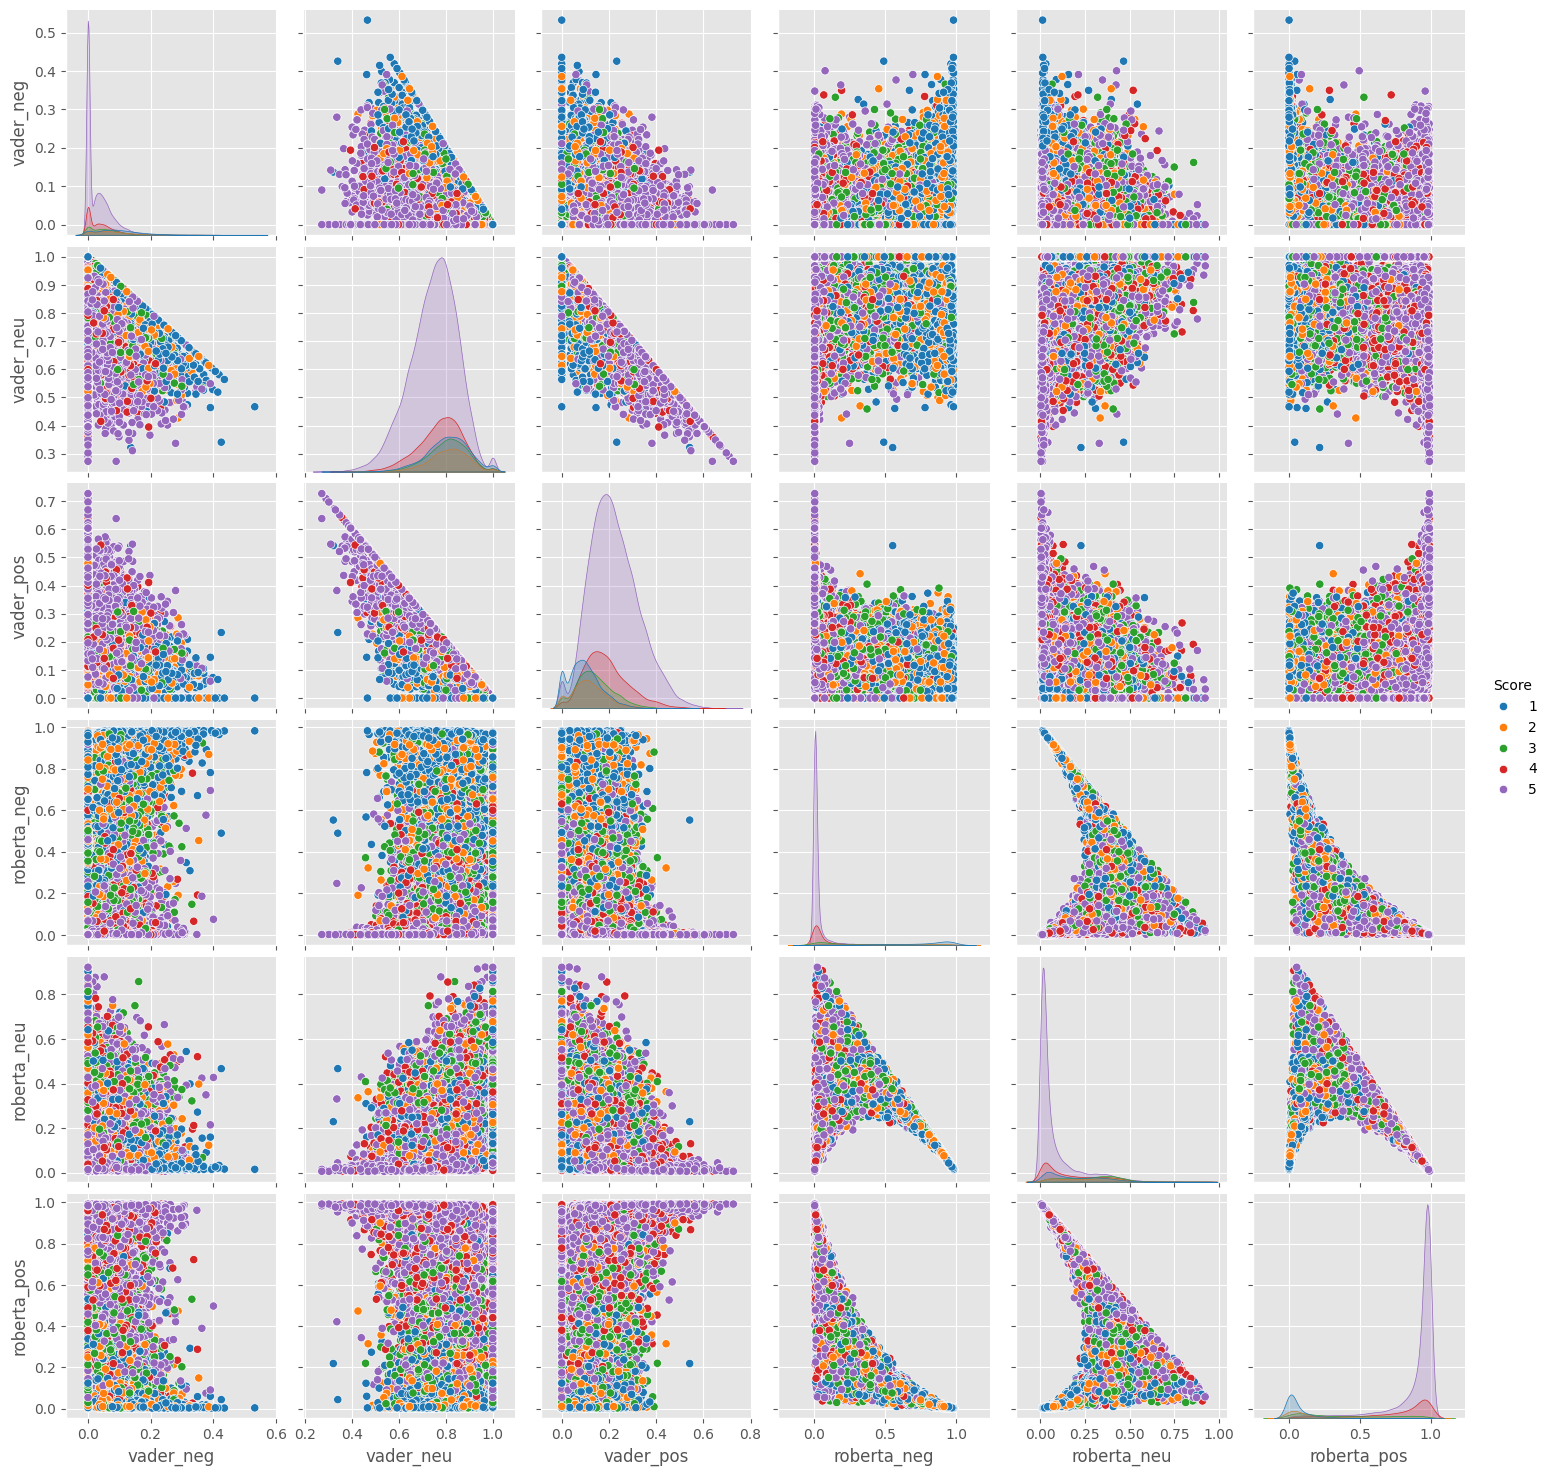

In [37]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [38]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'This was a great gift for my son & his wife - they have had many sleepless nights with a new baby. After New Years Day dinner we brewed one of the blends and had it with pie. The aroma and taste was excellent!'

In [39]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'I love coffee, I love mochas, I love amaretto.<br />This product however was disgusting !!!'

In [40]:
# nevative sentiment 5-Star view

In [41]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'THEY ARE DELICIOUS NOT SALTY YOU CAN SIT AND EAT 2-3 2 OUNCE BAGS AT A TIME I GIVE THESE 5 STARS PLUS I HAVE TO STOP MYSELF FROM EATING THEM THEY ARE DELICIOUS.'

In [42]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'pure smooth not sugar sweet, best for the price since Sams club stop selling syrup'

In [ ]:
# The Transformers Pipeline

In [44]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [62]:
from transformers import pipeline
import ipywidgets as widgets
from IPython.display import display

# Load sentiment analysis pipeline
sent_pipeline = pipeline("sentiment-analysis")

text_area = widgets.Textarea(
    value='',
    placeholder='Type your review here...',
    description='Review:',
    layout=widgets.Layout(width='99%', height='100px'),
    style={'description_width': 'initial'}
)

display(text_area)

analyze_button = widgets.Button(description="Analyze Sentiment")

# Output display
output = widgets.Output()

def analyze_sentiment(b):
    output.clear_output()
    with output:
        text = text_area.value.strip()
        if not text:
            print("⚠️ Please provide some input to analyze.")
        else:
            result = sent_pipeline(text)
            print(f"✅ Sentiment: {result[0]['label']} (Score: {result[0]['score']:.2f})")

# Bind the button click event
analyze_button.on_click(analyze_sentiment)

display(analyze_button, output)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Textarea(value='', description='Review:', layout=Layout(height='100px', width='99%'), placeholder='Type your r…

Button(description='Analyze Sentiment', style=ButtonStyle())

Output()

In [49]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Save the model and tokenizer to a directory
# model.save_pretrained("my_sentiment_model")
# tokenizer.save_pretrained("my_sentiment_model")


('my_sentiment_model\\tokenizer_config.json',
 'my_sentiment_model\\special_tokens_map.json',
 'my_sentiment_model\\vocab.json',
 'my_sentiment_model\\merges.txt',
 'my_sentiment_model\\added_tokens.json',
 'my_sentiment_model\\tokenizer.json')

In [50]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# model = AutoModelForSequenceClassification.from_pretrained("my_sentiment_model")
# tokenizer = AutoTokenizer.from_pretrained("my_sentiment_model")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Running predictions, please wait...

Total Samples    : 200
Correct Predictions : 175
Incorrect Predictions : 25
Accuracy         : 87.50%



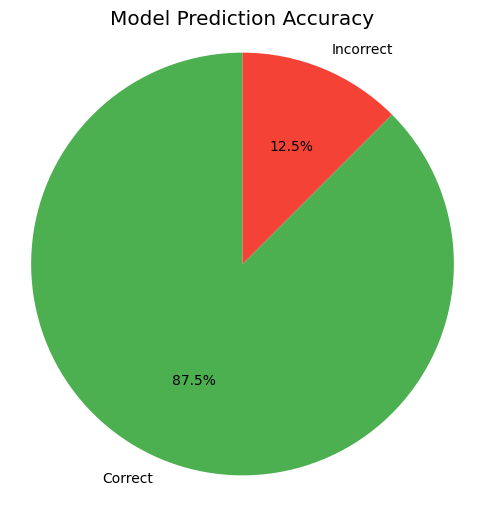

In [73]:
from transformers import pipeline
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load sentiment pipeline
sent_pipeline = pipeline("sentiment-analysis")

# Load CSV files
df_pos = pd.read_csv("positive_reviews.csv")
df_neg = pd.read_csv("negative_reviews.csv")

# Combine into one DataFrame
df = pd.concat([df_pos, df_neg]).reset_index(drop=True)

# Run predictions
print("Running predictions, please wait...\n")
df['predicted'] = df['text'].apply(lambda x: sent_pipeline(x)[0]['label'])

# Calculate metrics
total = len(df)
correct = sum(df['label'] == df['predicted'])
wrong = total - correct
accuracy = accuracy_score(df['label'], df['predicted'])

# Print results
print(f"Total Samples    : {total}")
print(f"Correct Predictions : {correct}")
print(f"Incorrect Predictions : {wrong}")
print(f"Accuracy         : {accuracy:.2%}\n")

# Visual: Pie chart of correct vs wrong
plt.figure(figsize=(6, 6))
plt.pie([correct, wrong],
        labels=['Correct', 'Incorrect'],
        autopct='%1.1f%%',
        colors=['#4CAF50', '#F44336'],
        startangle=90)
plt.title('Model Prediction Accuracy')
plt.axis('equal')
plt.show()
